<a href="https://colab.research.google.com/github/soeil1/Mineria-de-datos-google-golab/blob/main/Mineria%20de%20datos%20Google%20Coolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta sección se documenta la primera fase del proyecto de Minería de Datos, correspondiente a la metodología KDD (Knowledge Discovery in Databases). Esta fase abarca la preparación, limpieza y análisis exploratorio de los datos de incidentes viales proporcinado por el profesor.

Punto 1: Identificación del Universo de Datos
El objetivo de este punto fue definir la fuente de datos, filtrar el universo de interés y realizar un primer análisis exploratorio para formular una hipótesis.

In [8]:
import pandas as pd

print("--- Celda 1: Carga, Limpieza y Filtrado de Datos ---")

# --- 1. Carga y Limpieza de Nombres de Columna ---
try:
    # Asegúrate de haber subido el archivo 'inViales_2022.csv' a tu Colab
    # Y de haber montado Google Drive (ver la celda 47-PGuQ7W2X9)
    df = pd.read_csv("/content/inViales_2022.csv") # <-- PATH CORREGIDO
    print(f"Datos cargados correctamente. Forma original: {df.shape}")
except FileNotFoundError:
    print("Error: No se encontró el archivo 'inViales_2022.csv'.")
    print("Asegúrate de haberlo subido al panel izquierdo de Colab o de que la ruta en Google Drive es correcta.")
    # Si usamos Colab, no usamos exit(), solo detenemos la celda.
    raise

# Limpia espacios en blanco al inicio o final de TODOS los nombres de columnas
df.columns = df.columns.str.strip()

# --- 2. Filtrado de Datos (Puntos 1.a y 1.b) ---
try:
    # Condición 1: tipo_incidente_c4 == "Accidente"
    df_filtrado = df[df['tipo_incidente_c4'] == 'Accidente'].copy()
    print(f"Datos después de filtrar por 'Accidente': {df_filtrado.shape}")
except KeyError:
    print("Error: La columna 'tipo_incidente_c4' sigue sin encontrarse.")
    print("Por favor, verifica el nombre exacto de la columna en tu CSV.")
    raise

# Condición 2: incidente_c4 == "Choque con lesionados" O "Choque sin lesionados"
condiciones_incidente = (
    (df_filtrado['incidente_c4'] == 'Choque con lesionados') |
    (df_filtrado['incidente_c4'] == 'Choque sin lesionados')
)

# Aplicamos el segundo filtro
df_proyecto = df_filtrado[condiciones_incidente].copy()

print(f"Forma final de los datos del proyecto: {df_proyecto.shape}")

# Verificamos cuántos datos quedaron de cada clase
print("\nConteo de la variable objetivo (incidente_c4):")
print(df_proyecto['incidente_c4'].value_counts())

# --- 3. Creación de la Etiqueta 'target' (Punto 1.c) ---
# Transformamos el texto a números (0 y 1) para el modelo
df_proyecto.loc[:, 'target'] = df_proyecto['incidente_c4'].apply(
    lambda x: 1 if x == 'Choque con lesionados' else 0
)

print("\nSe creó la columna 'target' numérica:")
print(df_proyecto[['incidente_c4', 'target']].head())

# --- 4. Resumen Final ---
print("\nInformación del DataFrame final (df_proyecto):")
df_proyecto.info()

print("\n--- ¡Celda 1 completada! El DataFrame 'df_proyecto' está listo. ---")

--- Celda 1: Carga, Limpieza y Filtrado de Datos ---
Datos cargados correctamente. Forma original: (234938, 17)
Datos después de filtrar por 'Accidente': (209863, 17)
Forma final de los datos del proyecto: (175320, 17)

Conteo de la variable objetivo (incidente_c4):
incidente_c4
Choque sin lesionados    107578
Choque con lesionados     67742
Name: count, dtype: int64

Se creó la columna 'target' numérica:
            incidente_c4  target
0  Choque con lesionados       1
1  Choque con lesionados       1
2  Choque con lesionados       1
4  Choque con lesionados       1
5  Choque con lesionados       1

Información del DataFrame final (df_proyecto):
<class 'pandas.core.frame.DataFrame'>
Index: 175320 entries, 0 to 234937
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   folio              175320 non-null  object 
 1   fecha_creacion     175320 non-null  object 
 2   hora_creacion      175320 non-null  ob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Celda 2: Transformación y Matriz de Correlación (Puntos 1.e, 3, 4)

--- Celda 2: Transformación y Matriz de Correlación (Puntos 1.e, 3, 4) ---
Columna 'hora_creacion' convertida a 'hora_num'.
Columnas 'dia_semana' y 'alcaldia_inicio' convertidas a numéricas.

Matriz de Correlación (Valores):
                target  hora_num   dia_num  alcaldia_num  longitud   latitud
target        1.000000 -0.050231 -0.027393     -0.013725 -0.003724  0.013801
hora_num     -0.050231  1.000000  0.057052      0.010910 -0.003766 -0.016299
dia_num      -0.027393  0.057052  1.000000     -0.021287 -0.006168  0.028616
alcaldia_num -0.013725  0.010910 -0.021287      1.000000  0.377886 -0.304510
longitud     -0.003724 -0.003766 -0.006168      0.377886  1.000000 -0.072619
latitud       0.013801 -0.016299  0.028616     -0.304510 -0.072619  1.000000

Generando gráfica (Heatmap) de correlación...


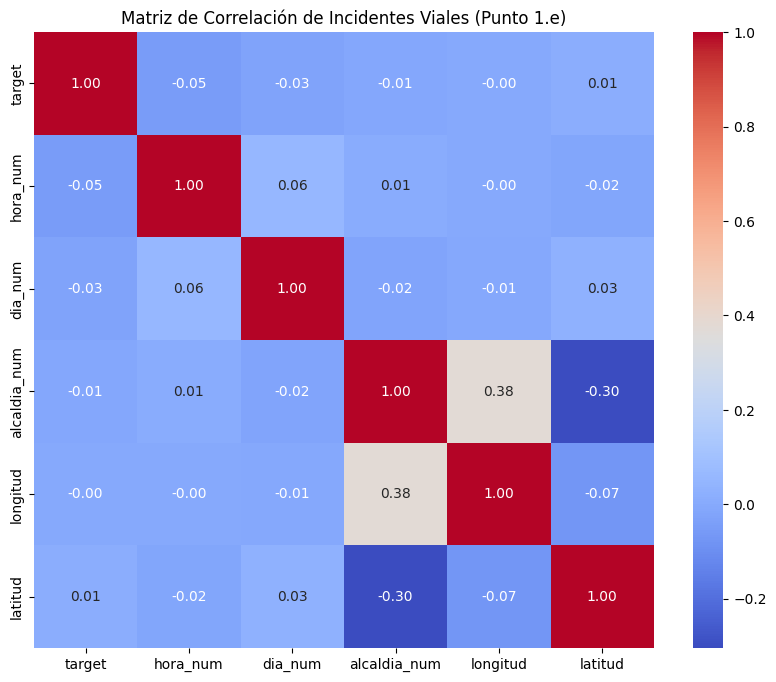


--- Celda 2 Matriz de Correlación ---


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np # numpy es una dependencia de pandas, la importamos por si acaso

print("--- Celda 2: Transformación y Matriz de Correlación (Puntos 1.e, 3, 4) ---")

# Es buena práctica hacer una copia para no modificar el DataFrame original
df_corr = df_proyecto.copy()

# --- 1. Transformación de Datos (Punto 4) ---

# a. Convertir 'hora_creacion' a número (0-23)
#    (Incluye la limpieza .str.strip() que descubrimos en el error anterior)
try:
    df_corr['hora_num'] = pd.to_datetime(df_corr['hora_creacion'].str.strip(), format='%H:%M:%S').dt.hour
    print("Columna 'hora_creacion' convertida a 'hora_num'.")
except Exception as e:
    print(f"Error al convertir hora: {e}")
    # Si falla, creamos una columna de 0s para poder continuar
    df_corr['hora_num'] = 0


# b. Convertir 'dia_semana' y 'alcaldia_inicio' a números
#    (También las limpiamos con .str.strip() por si acaso)
le = LabelEncoder() # LabelEncoder asigna un número a cada categoría

df_corr['dia_num'] = le.fit_transform(df_corr['dia_semana'].str.strip())
df_corr['alcaldia_num'] = le.fit_transform(df_corr['alcaldia_inicio'].str.strip())

print("Columnas 'dia_semana' y 'alcaldia_inicio' convertidas a numéricas.")

# --- 2. Cálculo de la Matriz de Correlación (Punto 1.e) ---

# Seleccionamos solo las columnas numéricas que nos interesan
columnas_numericas = [
    'target',          # Nuestra variable objetivo (0 o 1)
    'hora_num',        # La hora (0-23)
    'dia_num',         # El día de la semana (0-6)
    'alcaldia_num',    # La alcaldía (ej. 0 a 15)
    'longitud',        # Coordenada
    'latitud'          # Coordenada
]

# Calculamos la matriz
matriz_corr = df_corr[columnas_numericas].corr()

print("\nMatriz de Correlación (Valores):")
print(matriz_corr)

# --- 3. Visualización (Heatmap) ---

print("\nGenerando gráfica (Heatmap) de correlación...")

# Creamos la figura
plt.figure(figsize=(10, 8))

# Dibujamos el heatmap con seaborn
sns.heatmap(matriz_corr,
            annot=True,     # Muestra los números (anotaciones)
            cmap='coolwarm',  # Esquema de color (frío-cálido)
            fmt=".2f")      # Muestra los números con 2 decimales

plt.title("Matriz de Correlación de Incidentes Viales (Punto 1.e)")
plt.show() # Muestra la gráfica en el notebook

print("\n--- Celda 2 Matriz de Correlación ---")

Celda 3 (Modelo Supervisado - Regresión Logística)  Punto 5 (Modelo Supervisado)

--- Celda 3: Modelo Supervisado (Punto 5) ---

FASE 1: Preparando Features (X) y Target (y)...
Forma de X (pistas): (175320, 5)
Forma de y (respuesta): (175320,)

FASE 2: Transformando Features (limpiando y usando One-Hot Encoding)...
Aplicando One-Hot Encoding a: ['dia_semana', 'alcaldia_inicio']
Forma final de X (con dummies): (175320, 24)

FASE 3: Dividiendo datos en Entrenamiento (80%) y Prueba (20%)...
Datos de Entrenamiento (Train): (140256, 24)
Datos de Prueba (Test): (35064, 24)

FASE 4: Escalando los datos (StandardScaler)...
Datos de X_train y X_test escalados correctamente.

FASE 5: Entrenando el modelo de Regresión Logística...
¡Modelo entrenado exitosamente!

FASE 6: Realizando predicciones sobre los datos de Prueba...
Predicciones completadas.

--- PUNTO 5.c: Métricas de Evaluación ---

--- i. Matriz de Confusión ---


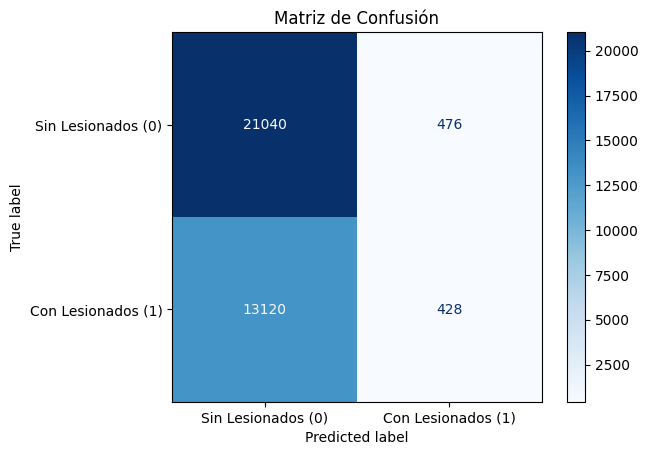

Verdaderos Negativos (VN): 21040 (Dijo 0, era 0)
Falsos Positivos (FP):   476 (Dijo 1, era 0) - Error Tipo I
Falsos Negativos (FN):   13120 (Dijo 0, era 1) - Error Tipo II
Verdaderos Positivos (VP): 428 (Dijo 1, era 1)

--- i. Accuracy: 0.6123 ---
El modelo acertó en el 61.23% del total de predicciones.

--- ii. Precision: 0.4735 ---
De todas las veces que el modelo dijo 'Con Lesionados' (1), acertó el 47.35%.

--- iii. Recall: 0.0316 ---
De todos los choques que REALMENTE tuvieron lesionados, el modelo 'encontró' al 3.16%.

--- iv. F1-Score: 0.0592 ---
El F1-Score (balance entre Precision y Recall) es 0.0592.

--- v. Curva ROC ---


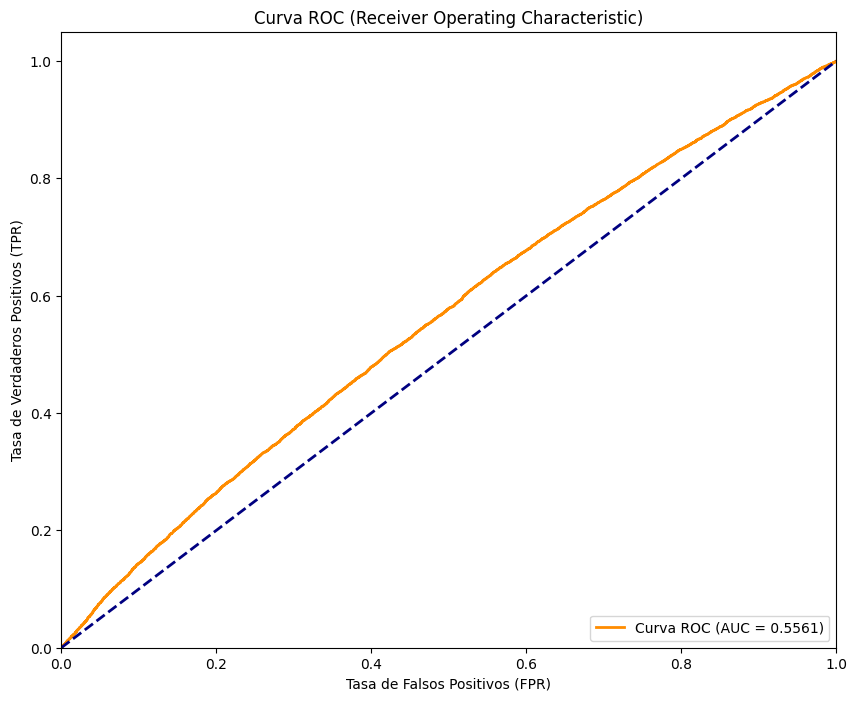

El Área Bajo la Curva (AUC) es: 0.5561
Un AUC de 0.5 es azar. Un AUC de 1.0 es perfecto.

--- ¡Celda 3 (Punto 5) completada! ---


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

print("--- Celda 3: Modelo Supervisado (Punto 5) ---")

# --- FASE 1: Preparación de Variables (Features X, Target y) ---
print("\nFASE 1: Preparando Features (X) y Target (y)...")

# Definimos las "pistas" (features) que usaremos
features_list = [
    'hora_creacion',
    'dia_semana',
    'alcaldia_inicio',
    'longitud',
    'latitud'
]

# Definimos la "respuesta" (target) que queremos predecir
target_col = 'target'

# Creamos 'X' (las pistas) y 'y' (la respuesta)
# Usamos .copy() para evitar advertencias de Pandas
X = df_proyecto[features_list].copy()
y = df_proyecto[target_col].copy()

print(f"Forma de X (pistas): {X.shape}")
print(f"Forma de y (respuesta): {y.shape}")

# --- FASE 2: Transformación de Features (One-Hot Encoding) ---
print("\nFASE 2: Transformando Features (limpiando y usando One-Hot Encoding)...")

# a. Convertir 'hora_creacion' a 'hora_num' (como en Celda 2)
X['hora_num'] = pd.to_datetime(X['hora_creacion'].str.strip(), format='%H:%M:%S').dt.hour

# b. Aplicar One-Hot Encoding (Dummies)
# Esta es la técnica CORRECTA para modelos de regresión,
# a diferencia del LabelEncoder que usamos solo para la matriz de correlación.
# 'get_dummies' crea nuevas columnas (ej. 'dia_semana_Lunes', 'dia_semana_Martes')
# con valores 0 o 1.
categorical_features = ['dia_semana', 'alcaldia_inicio']

print(f"Aplicando One-Hot Encoding a: {categorical_features}")
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# c. Limpieza final de X
# Eliminamos la columna original 'hora_creacion' (ya tenemos 'hora_num')
X = X.drop('hora_creacion', axis=1)

print(f"Forma final de X (con dummies): {X.shape}")


# --- FASE 3: División de Datos (Train-Test Split) ---
print("\nFASE 3: Dividiendo datos en Entrenamiento (80%) y Prueba (20%)...")

# X_train, y_train: Datos para "estudiar"
# X_test, y_test: Datos para el "examen final"
# test_size=0.2: Dejamos el 20% de los datos para el examen.
# random_state=42: Asegura que la división sea siempre la misma (reproducible).
# stratify=y: ¡MUY IMPORTANTE! Asegura que el 20% de prueba y el 80% de
#              entrenamiento tengan la MISMA proporción de '1s' (lesionados)
#              que el conjunto de datos original.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Datos de Entrenamiento (Train): {X_train.shape}")
print(f"Datos de Prueba (Test): {X_test.shape}")

# --- FASE 4: Escalado de Datos (StandardScaler) ---
print("\nFASE 4: Escalando los datos (StandardScaler)...")

# Creamos el escalador
scaler = StandardScaler()

# 1. "Ajustamos" el escalador SOLO con los datos de ENTRENAMIENTO
#    (Aprende la media y desviación de X_train)
# 2. "Transformamos" los datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)

# 3. "Transformamos" los datos de PRUEBA usando el ajuste anterior.
#    ¡NUNCA "ajustamos" (fit) con los datos de prueba!
X_test_scaled = scaler.transform(X_test)

print("Datos de X_train y X_test escalados correctamente.")


# --- FASE 5: Entrenamiento del Modelo (Regresión Logística) ---
print("\nFASE 5: Entrenando el modelo de Regresión Logística...")

# Creamos el modelo
# max_iter=1000 para asegurar que el modelo tenga tiempo de "converger"
model = LogisticRegression(random_state=42, max_iter=1000)

# "Entrenamos" el modelo:
# Le damos las pistas (X_train_scaled) y las respuestas (y_train)
model.fit(X_train_scaled, y_train)

print("¡Modelo entrenado exitosamente!")


# --- FASE 6: Predicción (El "Examen") ---
print("\nFASE 6: Realizando predicciones sobre los datos de Prueba...")

# Usamos el modelo entrenado para predecir las respuestas
# de las pistas de prueba (X_test_scaled) que NUNCA vio.
y_pred = model.predict(X_test_scaled)

print("Predicciones completadas.")


# --- PUNTO 5.c: Métricas de Evaluación ---
print("\n--- PUNTO 5.c: Métricas de Evaluación ---")

# 0. Matriz de Confusión (La base de todo)
print("\n--- i. Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
# 'y_test' son las respuestas reales
# 'y_pred' son las predicciones del modelo

# Graficamos la Matriz de Confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=['Sin Lesionados (0)', 'Con Lesionados (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

# Imprimimos la matriz en texto para claridad
# VN | FP
# FN | VP
print(f"Verdaderos Negativos (VN): {cm[0][0]} (Dijo 0, era 0)")
print(f"Falsos Positivos (FP):   {cm[0][1]} (Dijo 1, era 0) - Error Tipo I")
print(f"Falsos Negativos (FN):   {cm[1][0]} (Dijo 0, era 1) - Error Tipo II")
print(f"Verdaderos Positivos (VP): {cm[1][1]} (Dijo 1, era 1)")


# i. Accuracy (Exactitud)
acc = accuracy_score(y_test, y_pred)
print(f"\n--- i. Accuracy: {acc:.4f} ---")
print(f"El modelo acertó en el {acc*100:.2f}% del total de predicciones.")

# ii. Precision (Precisión)
prec = precision_score(y_test, y_pred)
print(f"\n--- ii. Precision: {prec:.4f} ---")
print(f"De todas las veces que el modelo dijo 'Con Lesionados' (1), acertó el {prec*100:.2f}%.")

# iii. Recall (Sensibilidad)
rec = recall_score(y_test, y_pred)
print(f"\n--- iii. Recall: {rec:.4f} ---")
print(f"De todos los choques que REALMENTE tuvieron lesionados, el modelo 'encontró' al {rec*100:.2f}%.")

# iv. F1-Score
f1 = f1_score(y_test, y_pred)
print(f"\n--- iv. F1-Score: {f1:.4f} ---")
print(f"El F1-Score (balance entre Precision y Recall) es {f1:.4f}.")


# v. Curva ROC y AUC
print("\n--- v. Curva ROC ---")
# Para la curva ROC, necesitamos las "probabilidades" (no solo 0 o 1)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculamos los puntos de la curva
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculamos el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)

# Graficamos
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Línea de "azar"
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()

print(f"El Área Bajo la Curva (AUC) es: {roc_auc:.4f}")
print("Un AUC de 0.5 es azar. Un AUC de 1.0 es perfecto.")
print("\n--- ¡Celda 3 (Punto 5) completada! ---")

Código para la Celda 4 (Iteración 1: class_weight='balanced')

--- Celda 4: Modelo Supervisado - Iteración 1 (Ajuste de Parámetros) ---
Ajuste: class_weight='balanced'

FASE 5: Entrenando el modelo AJUSTADO...
¡Modelo 'balanceado' entrenado exitosamente!

FASE 6: Realizando predicciones con el nuevo modelo...
Predicciones completadas.

--- PUNTO 5.c: Métricas de Evaluación (Iteración 1) ---

--- i. Matriz de Confusión (balanceada) ---


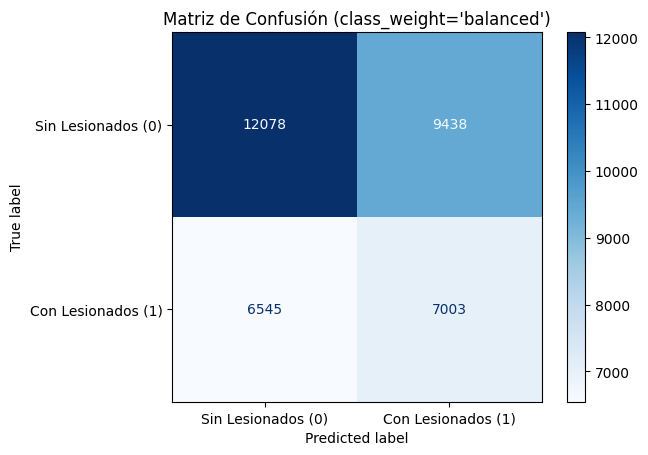

Verdaderos Negativos (VN): 12078
Falsos Positivos (FP):   9438
Falsos Negativos (FN):   6545
Verdaderos Positivos (VP): 7003

--- i. Accuracy: 0.5442 ---
El modelo acertó en el 54.42% del total de predicciones.

--- ii. Precision: 0.4259 ---
De todas las veces que el modelo dijo 'Con Lesionados', acertó el 42.59%.

--- iii. Recall: 0.5169 ---
De todos los choques que REALMENTE tuvieron lesionados, el modelo 'encontró' al 51.69%.

--- iv. F1-Score: 0.4670 ---
El F1-Score (balance) es 0.4670.

--- v. Curva ROC (balanceada) ---


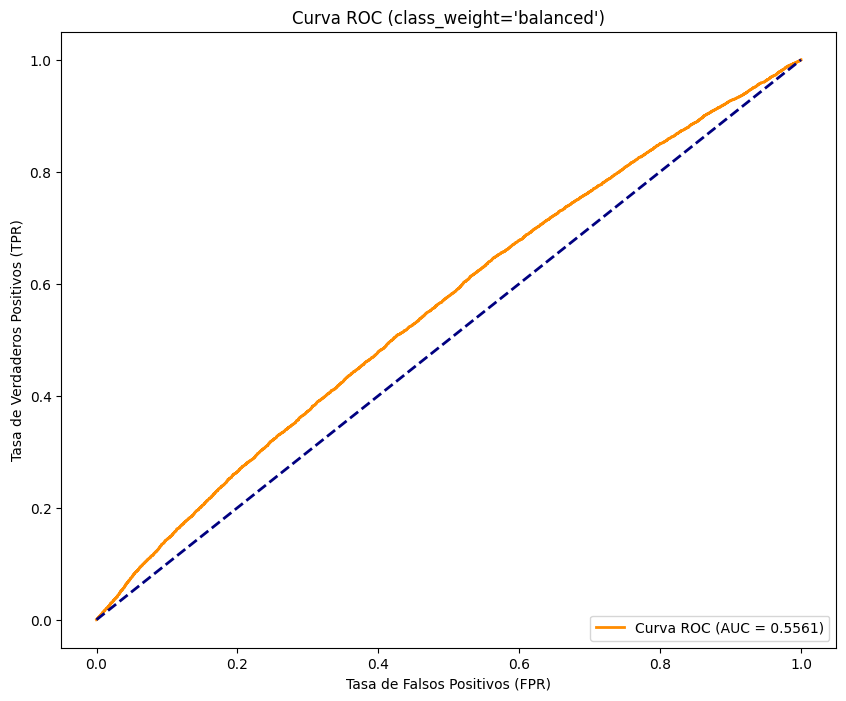

El Área Bajo la Curva (AUC) es: 0.5561

--- ¡Celda 4 (Iteración 1) completada! ---


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# ¡Importante! Re-usamos las variables X, y, X_train, etc. que ya
# existen en la memoria del Notebook gracias a la Celda 3.
# No necesitamos re-procesar todo, solo re-entrenar y re-evaluar.

print("--- Celda 4: Modelo Supervisado - Iteración 1 (Ajuste de Parámetros) ---")
print("Ajuste: class_weight='balanced'")

# --- FASE 5 (MODIFICADA): Entrenamiento del Modelo Ajustado ---
print("\nFASE 5: Entrenando el modelo AJUSTADO...")

# Creamos el modelo
# max_iter=1000 para asegurar que el modelo tenga tiempo de "converger"

# --- ¡¡¡ ESTE ES EL ÚNICO CAMBIO !!! ---
model_balanced = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # <--- ¡AQUÍ ESTÁ EL AJUSTE!
)
# ------------------------------------

# "Entrenamos" el nuevo modelo con los MISMOS datos de entrenamiento
model_balanced.fit(X_train_scaled, y_train)

print("¡Modelo 'balanceado' entrenado exitosamente!")


# --- FASE 6 (MODIFICADA): Predicción con el Modelo Ajustado ---
print("\nFASE 6: Realizando predicciones con el nuevo modelo...")

# Usamos el nuevo modelo para predecir sobre los MISMOS datos de prueba
y_pred_balanced = model_balanced.predict(X_test_scaled)

print("Predicciones completadas.")


# --- PUNTO 5.c (MODIFICADO): Métricas del Modelo Ajustado ---
print("\n--- PUNTO 5.c: Métricas de Evaluación (Iteración 1) ---")

# 0. Matriz de Confusión
print("\n--- i. Matriz de Confusión (balanceada) ---")
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_balanced,
                            display_labels=['Sin Lesionados (0)', 'Con Lesionados (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión (class_weight='balanced')")
plt.show()

print(f"Verdaderos Negativos (VN): {cm_balanced[0][0]}")
print(f"Falsos Positivos (FP):   {cm_balanced[0][1]}")
print(f"Falsos Negativos (FN):   {cm_balanced[1][0]}")
print(f"Verdaderos Positivos (VP): {cm_balanced[1][1]}")

# i. Accuracy
acc_bal = accuracy_score(y_test, y_pred_balanced)
print(f"\n--- i. Accuracy: {acc_bal:.4f} ---")
print(f"El modelo acertó en el {acc_bal*100:.2f}% del total de predicciones.")

# ii. Precision
prec_bal = precision_score(y_test, y_pred_balanced)
print(f"\n--- ii. Precision: {prec_bal:.4f} ---")
print(f"De todas las veces que el modelo dijo 'Con Lesionados', acertó el {prec_bal*100:.2f}%.")

# iii. Recall
rec_bal = recall_score(y_test, y_pred_balanced)
print(f"\n--- iii. Recall: {rec_bal:.4f} ---")
print(f"De todos los choques que REALMENTE tuvieron lesionados, el modelo 'encontró' al {rec_bal*100:.2f}%.")

# iv. F1-Score
f1_bal = f1_score(y_test, y_pred_balanced)
print(f"\n--- iv. F1-Score: {f1_bal:.4f} ---")
print(f"El F1-Score (balance) es {f1_bal:.4f}.")

# v. Curva ROC y AUC
print("\n--- v. Curva ROC (balanceada) ---")
y_pred_proba_bal = model_balanced.predict_proba(X_test_scaled)[:, 1]
fpr_bal, tpr_bal, _ = roc_curve(y_test, y_pred_proba_bal)
roc_auc_bal = auc(fpr_bal, tpr_bal)

plt.figure(figsize=(10, 8))
plt.plot(fpr_bal, tpr_bal, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc_bal:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title("Curva ROC (class_weight='balanced')")
plt.legend(loc="lower right")
plt.show()

print(f"El Área Bajo la Curva (AUC) es: {roc_auc_bal:.4f}")
print("\n--- ¡Celda 4 (Iteración 1) completada! ---")

Celda 5 (Método del Codo)

--- Celda 5: Modelo No Supervisado (Punto 6) - Método del Codo ---
Datos seleccionados para clustering: (175320, 2)
Datos escalados correctamente.

Calculando el Método del Codo (probando de 2 a 10 clusters)...
Esto puede tardar un momento...


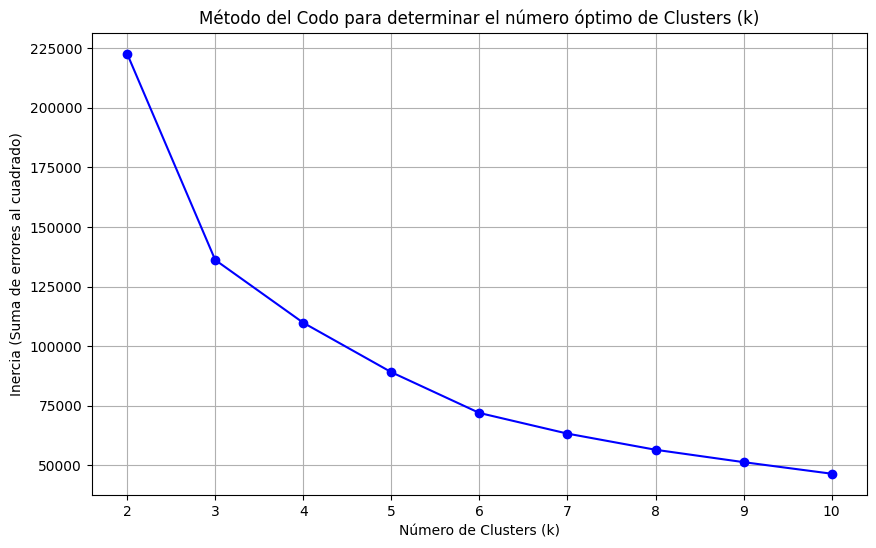


--- ¡Celda 5 completada! Revisa la gráfica. ---


In [12]:
# --- CORRECCIÓN DEL ERROR (Instalar actualización) ---
# Ejecutamos esto primero para arreglar el bug de 'NoneType'
!pip install --upgrade threadpoolctl > /dev/null

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import threadpoolctl # Importamos para asegurar que se cargue la nueva versión

print("--- Celda 5: Modelo No Supervisado (Punto 6) - Método del Codo ---")

# --- 1. Selección de Variables para Clusterización ---
# Vamos a agrupar basándonos en la UBICACIÓN GEOGRÁFICA.
# Tomamos Latitud y Longitud.
features_cluster = ['latitud', 'longitud']

# Creamos la matriz X para el clustering
X_cluster = df_proyecto[features_cluster].copy()

print(f"Datos seleccionados para clustering: {X_cluster.shape}")
# print(X_cluster.head())

# --- 2. Escalado de Datos ---
# K-Means es sensible a las distancias, así que es vital escalar.
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

print("Datos escalados correctamente.")

# --- 3. Método del Codo (Punto 6.a.ii) ---
print("\nCalculando el Método del Codo (probando de 2 a 10 clusters)...")
print("Esto puede tardar un momento...")

inercias = []
rango_k = range(2, 11) # Probaremos de 2 a 10 clusters

for k in rango_k:
    # Creamos un K-Means temporal con k grupos
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_cluster_scaled)

    # Guardamos la "inercia" (suma de distancias al cuadrado)
    inercias.append(kmeans_temp.inertia_)

# --- 4. Graficar el Codo ---
plt.figure(figsize=(10, 6))
plt.plot(rango_k, inercias, marker='o', linestyle='-', color='b')
plt.title('Método del Codo para determinar el número óptimo de Clusters (k)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Suma de errores al cuadrado)')
plt.grid(True)
plt.xticks(rango_k)
plt.show()

print("\n--- ¡Celda 5 completada! Revisa la gráfica. ---")

Celda 6 (Clusterización Final)

--- Celda 6: Ejecución de K-Means y Validación (Punto 6) ---
Número de clusters elegido: 5
Entrenando K-Means final...
¡Clusterización completada! Se agregó la columna 'cluster' al DataFrame.

Generando mapa de clusters...


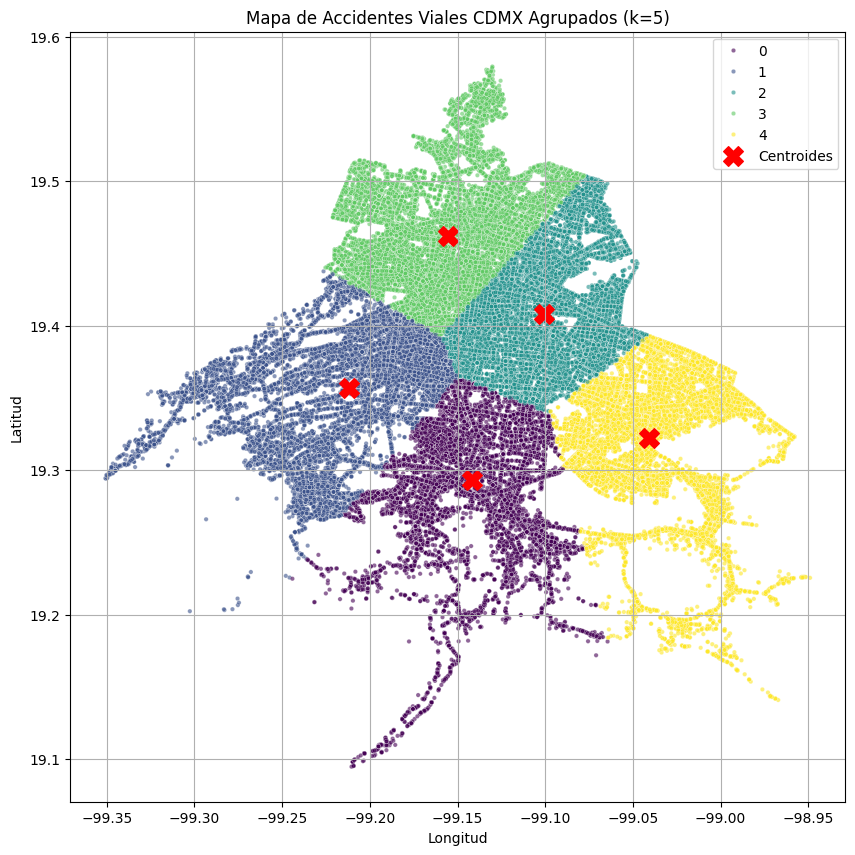


Calculando Silhouette Score (Validación)...
Nota: Usando una muestra aleatoria de 10000 datos para calcular la silueta rápidamente.

--- Métrica de Silueta (Silhouette Score): 0.3469 ---
Interpretación: Cercano a 1 es perfecto. Cercano a 0 es superposición. Negativo es error.

--- ¡Celda 6 completada! ---


In [13]:
import seaborn as sns
from sklearn.metrics import silhouette_score

print("--- Celda 6: Ejecución de K-Means y Validación (Punto 6) ---")

# --- 1. Configuración ---
k_optimo = 5  # Decidido por el método del codo
print(f"Número de clusters elegido: {k_optimo}")

# --- 2. Ejecución del Modelo Final (Punto 6.a.iii) ---
print("Entrenando K-Means final...")
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)

# Entrenamos con los datos escalados (X_cluster_scaled viene de la Celda 5)
kmeans_final.fit(X_cluster_scaled)

# Asignamos las etiquetas (0, 1, 2, 3, 4) a nuestros datos originales
df_proyecto['cluster'] = kmeans_final.labels_

print("¡Clusterización completada! Se agregó la columna 'cluster' al DataFrame.")


# --- 3. Visualización Geográfica (El "Mapa") ---
print("\nGenerando mapa de clusters...")
plt.figure(figsize=(10, 10))

# Usamos Longitud (X) y Latitud (Y) para pintar el mapa
sns.scatterplot(
    data=df_proyecto,
    x='longitud',
    y='latitud',
    hue='cluster',      # Colorear por número de cluster
    palette='viridis',  # Colores bonitos
    s=10,               # Tamaño del punto (pequeño para ver mejor)
    alpha=0.6           # Transparencia
)

# Pintamos también los CENTROIDES (los puntos centrales de cada zona)
# Ojo: Los centroides están escalados, hay que "des-escalarlos" para graficarlos bien
centroides_reales = scaler_cluster.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(
    centroides_reales[:, 1], # Longitud del centroide
    centroides_reales[:, 0], # Latitud del centroide
    c='red',
    s=200,
    marker='X',
    label='Centroides'
)

plt.title(f'Mapa de Accidentes Viales CDMX Agrupados (k={k_optimo})')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.grid(True)
plt.show()


# --- 4. Validación: Silhouette Score (Punto 6.a.v) ---
print("\nCalculando Silhouette Score (Validación)...")
# ADVERTENCIA: Calcular Silhouette con 175,000 datos tarda HORAS y puede tirar Colab.
# SOLUCIÓN PROFESIONAL: Usamos una muestra representativa (ej. 10,000 datos).
# Es estadísticamente válido y mucho más rápido.

sample_size = 10000
if len(X_cluster_scaled) > sample_size:
    print(f"Nota: Usando una muestra aleatoria de {sample_size} datos para calcular la silueta rápidamente.")
    from sklearn.utils import resample
    X_sample, labels_sample = resample(
        X_cluster_scaled,
        kmeans_final.labels_,
        n_samples=sample_size,
        random_state=42
    )
    score = silhouette_score(X_sample, labels_sample)
else:
    score = silhouette_score(X_cluster_scaled, kmeans_final.labels_)

print(f"\n--- Métrica de Silueta (Silhouette Score): {score:.4f} ---")
print("Interpretación: Cercano a 1 es perfecto. Cercano a 0 es superposición. Negativo es error.")
print("\n--- ¡Celda 6 completada! ---")